# G-MODE KPFM with Fast Free Force Recovery (F3R)
### Oak Ridge National Laboratory
### *Liam Collins, Anugrah Saxena, Rama Vasudevan and Chris Smith*

This notebook will allow  fast KPFM by recovery of the electrostatic foce directly from the photodetector response. Information on the procedure can be found in Collins et al. ([DOI: 10.1021/acsnano.7b02114](http://pubs.acs.org/doi/abs/10.1021/acsnano.7b02114)) In this notebook the following procedured are performed. <br>

#### (1) Models the Cantilever Transfer Function (H(w)) 
**(1a)** Translates Tune file to H5 <br>
**(1b)** Fits Cantilever resonances to SHO Model <br>
**(1c)** Constructs the effective cantilever transfer function (H(w)) from SHO fits of the tune. <br>
#### (2)Load, Translate and Denoize the G-KPFM data 
**(2a)** Loads and translates the .mat file containing the image data to .H5 file format. <br>
**(2b)** Fourier Filters data. <br>
**(2bii)** Checks Force Recovery for 1 pixel...here you need to find the phase offset used in 3. <br>
**(2c- optional)** PCA Denoizing.<br>   
        
#### (3) Fast Free Force Reconstruction   
**(3a)** Divides filtered displacement Y(w) by the effective transfer function (H(w)). <br>
<font color=red>This takes some time, can we parallelize it?. One option would be to incorperate it into the FFT filtering **step (2b** <br></font>
**(3b)** iFFT the response above a user defined noise floor to recovery Force in time domain.<br>
**(3c)** Phase correction (from step 2biii).<br>
<font color=red>I havent settled on the best way to find the phase shift required, but I see ye are working towards incorperating a phase shift into the filtering <br></font>

#### (4) Data Analysis
**(4a)** Parabolic fitting to extract CPD.<br>
<font color=red>Needs to be parallilized and output written to H5 file correctly. <br></font>

#### (5) Data Visualization
**(5a)** Visualization and clustering of fitting parameters and CPD.<br>
<font color=red>GIF movies and Kmeans clustering will be added. <br></font>

**<font color=blue> Change the filepath below, used for storing images <br></font>**

In [2]:

output_filepath = r'E:\ORNL\20191221_BAPI\BAPI21_2ms_700mA__0011'

save_figure = True 


## Installing required package

In [3]:
# !pip install h5py matplotlib numpy scipy sklearn pycroscopy numpy

# Checks Python Version
import sys
if sys.version_info < (3, 5):
    print('''This notebook was optimized to work on Python 3.5. 
    While it may also run on other Python versions, 
    functionality and performance are not guaranteed
    Please consider upgrading your python version.''')

## Configure Notebook

In [4]:
# set up notebook to show plots within the notebook
%matplotlib inline
%precision %.4g

# Import necessary libraries:

# Visualization:
import matplotlib.pyplot as plt
from IPython.display import display

# General utilities:
import os
import sys
from scipy.signal import correlate

# Interactive Value picker
import ipywidgets as widgets

# Computation:
import numpy as np
import numpy.polynomial.polynomial as npPoly

# Parallel computation library:
try:
    import joblib
except ImportError:
    warn('joblib not found.  Will install with pip.')
    import pip
    pip.main(['install', 'joblib'])
import joblib

import h5py

# multivariate analysis:
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF

#os.chdir(r'C:\Users\lz1\Documents\GitHub\pycroscopy')
# Finally, pycroscopy itself
import pycroscopy as px

# Define Layouts for Widgets
lbl_layout=dict(
    width='15%'
)
widget_layout=dict(
    width='15%',margin='0px 0px 5px 12px'
)
button_layout=dict(
    width='15%',margin='0px 0px 0px 5px'
)

### Define Cantilever Parameters

Here you should input the calibrated parameters of the tip from your experiment. In particular the lever sensitivity (m/V) and Spring Constant (N/m) which will be used to convert signals to displacement and force respectively.

In [5]:
# 'k', 'invols', 'Thermal_Q', 'Thermal_resonance'
cantl_parms = dict()
cantl_parms['k']=1.7 # N/M
cantl_parms['invols'] = 82.76e-9 #m/V

print(cantl_parms)

{'k': 1.7, 'invols': 8.276e-08}



## Step 1.) Model the Cantilever Transfer Function

First we need to read in the tune file for the cantilever your used to perform your measurment with. This tune show capture the "free" SHO parameters of the cantilever. If you have previously translated this data you can change the data type in the bottom right corner to .h5, others click the parms file.txt

 <font color=red>Chris, Ive noticed that the GtuneTranslator sometimes corrupts the parms.txt file. <br></font>

#### Step 1a. Translates Tune file to HF5 format
**<font color=blue> Note: This is a litte buggy, sometimes you need to do it twice, or point to H5 if already translated. I will find Fix <br></font>**

In [6]:
input_file_path = px.io_utils.uiGetFile(caption='Select translated .h5 file or raw experiment data',
                                        file_filter='Parameters for raw G-Line data (*.dat);; \
                                        Translated file (*.h5)')


tune_path, _ = os.path.split(input_file_path)
tune_file_base_name=os.path.basename(tune_path)

if input_file_path.endswith('.dat'):
    print('Translating raw data to h5. Please wait')
    tran=px.GTuneTranslator()
    h5_path=tran.translate(input_file_path)
else:
    h5_path = input_file_path
    
    

Translating raw data to h5. Please wait
Reading line 0 of 4
Finished reading file: E:/ORNL/20191221_BAPI/BAPI22_TUNE__0009\BAPI22_TUNE__0009_bigtime_00.dat!
Reading line 0 of 4
Finished reading file: E:/ORNL/20191221_BAPI/BAPI22_TUNE__0009\BAPI22_TUNE__0009_bigtime_01.dat!
G-Tune translation complete!


#### Step 1b. Extract the Resonance Modes Considered in the Force Reconstruction

In [7]:
#define number of eigenmodes to consider
num_bandsVal=2

#define bands (center frequency +/- bandwith)
MB0_w1 = 57E3 - 20E3
MB0_w2 = 57E3 + 20E3
MB1_w1 = 370E3 - 20E3
MB1_w2 = 370E3 + 20E3

MB1_amp = 30E-9
MB2_amp = 1E-9


MB_parm_vec = np.array([MB1_amp,MB0_w1,MB0_w2,MB1_amp,MB1_w1,MB1_w2])
MB_parm_vec.resize(2,3)
band_edge_mat = MB_parm_vec[:,1:3]

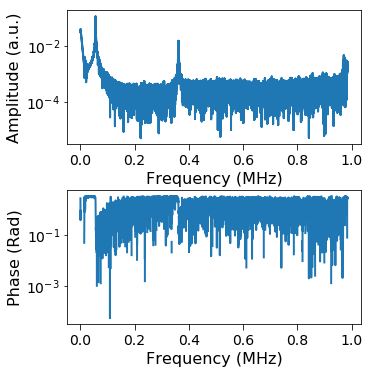

In [8]:
hdf = px.ioHDF5(h5_path)
h5_file = hdf.file
h5_resp = px.hdf_utils.getDataSet(hdf.file, 'Raw_Data')[0]
h5_main = px.hdf_utils.getDataSet(hdf.file, 'Raw_Data')[-1]

parms_dict = h5_main.parent.parent.attrs

samp_rate = parms_dict['IO_rate_[Hz]']
ex_freq = parms_dict['BE_center_frequency_[Hz]']

N_points = parms_dict['num_bins']
N_points_per_line =parms_dict['points_per_line']
N_points_per_pixel = parms_dict['num_bins']

w_vec2 = np.linspace(-0.5 * samp_rate, 0.5 * samp_rate - 1.0*samp_rate / N_points_per_line, N_points_per_line)

dt = 1/samp_rate
df = 1/dt


# Response
A_pd = np.mean(h5_resp, axis=0)
yt0_tune = A_pd - np.mean(A_pd)
Yt0_tune = np.fft.fftshift(np.fft.fft(yt0_tune,N_points_per_line)*dt)

# BE_wave_train
BE_pd = np.mean(h5_main, axis=0)
f0 = BE_pd - np.mean(BE_pd)
F0 = np.fft.fftshift(np.fft.fft(f0,N_points_per_line)*dt)

##The value here on right represents the excited bins
excited_bin_ind = np.where(np.abs(F0)>1e-3)
TF_vec = Yt0_tune/F0

plt.figure(2)
plt.subplot(2,1,1)
plt.semilogy(np.abs(w_vec2[excited_bin_ind])*1E-6,np.abs(TF_vec[excited_bin_ind]))
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude (a.u.)')
plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)
plt.subplot(2,1,2)
plt.semilogy(np.abs(w_vec2[excited_bin_ind])*1E-6,np.angle(TF_vec[excited_bin_ind]))
plt.xlabel('Frequency (MHz)')
plt.ylabel('Phase (Rad)')
plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)

#### Step 1c. Construct an effective Transfer function (TF_Norm) from SHO fits

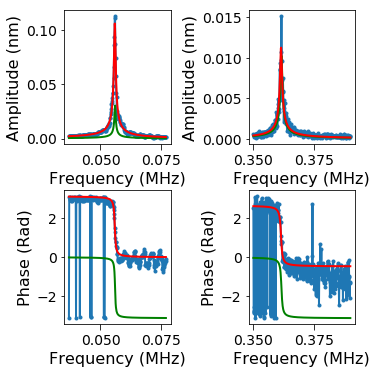

In [9]:
TunePhase = -np.pi
num_bands = band_edge_mat.shape[0]
coef_mat = np.zeros((num_bands,4))
coef_guess_vec = np.zeros((4))
TF_fit_vec = np.zeros((w_vec2.shape))
TFb_vec = TF_vec[excited_bin_ind]
wb = w_vec2[excited_bin_ind]


for k1 in range(num_bandsVal):
    # locate the fitting region
    w1 = band_edge_mat[k1][0]
    w2 = band_edge_mat[k1][1]
    bin_ind1 = np.where(np.abs(w1-wb) == np.min(np.abs(w1-wb)))[0][0]
    bin_ind2 = np.where(np.abs(w2-wb) == np.min(np.abs(w2-wb)))[0][0]
    response_vec = TFb_vec[bin_ind1:bin_ind2+1].T
    wbb = wb[bin_ind1:bin_ind2+1].T/1e6
    
    if k1 == 0:
        Q_guess = 120    
    elif k1 == 1:
        Q_guess = 500
    else:
        Q_guess = 700

    response_mat = np.array([np.real(response_vec), np.imag(response_vec)]).T
    A_max_ind = np.argmax(np.abs(response_vec))
    A_max = response_vec[A_max_ind]
    A_guess = A_max/Q_guess
    wo_guess = wbb[A_max_ind]

    if k1 == 0:
        phi_guess = TunePhase

    coef_guess_vec[0] = np.real(A_guess)
    coef_guess_vec[1] = wo_guess
    coef_guess_vec[2] = Q_guess
    coef_guess_vec[3] = phi_guess

    LL_vec = [0,w1/1E6,1,np.pi]
    UL_vec = [float("inf"),w2/1E6,10000,-np.pi]
    
    coef_vec = px.be_sho.SHOestimateGuess(response_vec,wbb,10)
   
   # coef_vec = coef_guess_vec
    response_guess_vec = px.be_sho.SHOfunc(coef_guess_vec,wbb)
    response_fit_vec = px.be_sho.SHOfunc(coef_vec,wbb)
    
   
    
    coef_vec[1] = coef_vec[1]*1E6
    coef_mat[k1,:] = coef_vec
    
    response_fit_full_vec = px.be_sho.SHOfunc(coef_vec,w_vec2)
    
    TF_fit_vec = TF_fit_vec + response_fit_full_vec # check for length and dimension
    
    fig= plt.figure(10)
    plt.subplot(num_bands,2,k1+1)
    plt.plot(wbb,np.abs(response_vec),'.-')
    plt.plot(wbb,np.abs(response_guess_vec),c='g')
    plt.plot(wbb,np.abs(response_fit_vec),c='r') 
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('Amplitude (nm)')
    plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)
    
    #plt.figure(11)
    plt.subplot(num_bands,2,(k1+1)+2)
    plt.plot(wbb,np.angle(response_vec),'.-')
    plt.plot(wbb,np.angle(response_guess_vec),c='g')
    plt.plot(wbb,np.angle(response_fit_vec),c='r')
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('Phase (Rad)')
    plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)
    
    if save_figure == True:
        fig.savefig(output_filepath+'\SHOFitting.eps', format='eps')
        fig.savefig(output_filepath+'\SHOFitting.tif', format='tiff')


In [10]:
Q = coef_mat[0,2]
TF_norm = ((TF_fit_vec- np.min(np.abs(TF_fit_vec)))/np.max(np.abs(TF_fit_vec))- np.min(np.abs(TF_fit_vec)))*Q

In [11]:
hdf.close()

# Step (2) Load, Translate and Denoize the G-KPFM data 

#### Step (2a) Load and Translates image file to .H5 file format. <br>

In [18]:
input_file_path = px.io_utils.uiGetFile(caption='Select translated .h5 file or raw experiment data',
                                        file_filter='Parameters for raw G-Line data (*.dat);; \
                                        Translated file (*.h5)')

folder_path, _ = os.path.split(input_file_path)

if input_file_path.endswith('.dat'):
    print('Translating raw data to h5. Please wait')
    tran = px.GLineTranslator()
    h5_path = tran.translate(input_file_path)
else:
    h5_path = input_file_path

#### Extract some relevant parameters

In [19]:
hdf = px.ioHDF5(h5_path)

h5_main = px.hdf_utils.getDataSet(hdf.file,'Raw_Data')[0]
h5_spec_vals = px.hdf_utils.getAuxData(h5_main, auxDataName='Spectroscopic_Values')[0]
h5_spec_inds=px.hdf_utils.getAuxData(h5_main, auxDataName='Spectroscopic_Indices')[0]

parms_dict = h5_main.parent.parent.attrs

samp_rate = parms_dict['IO_rate_[Hz]']
ex_freq = parms_dict['BE_center_frequency_[Hz]']
num_rows = parms_dict['grid_num_rows']
num_cols = parms_dict['grid_num_cols']
h5_pos_vals=px.hdf_utils.getAuxData(h5_main, auxDataName='Position_Values')[0]
h5_pos_inds=px.hdf_utils.getAuxData(h5_main, auxDataName='Position_Indices')[0]

pixel_ex_wfm = h5_spec_vals[0, :int(h5_spec_vals.shape[1]/num_cols)]
num_pts = h5_main.shape[1]
pnts_per_pix=int(num_pts/num_cols)

# Getting ancillary information and other parameters
#h5_spec_vals = px.hdf_utils.getAuxData(h5_main, auxDataName=['Spectroscopic_Values'])[0]

# Excitation waveform for a single line / row of data
excit_wfm = h5_spec_vals.value

# Preparing the frequency axis:
w_vec = 1E-3*np.linspace(-0.5*samp_rate, 0.5*samp_rate - samp_rate/num_pts, num_pts)
w_vec_pix = 1E-3*np.linspace(-0.5*samp_rate, 0.5*samp_rate - samp_rate/pnts_per_pix, pnts_per_pix)


# Preparing the time axis:
t_vec_line = 1E3*np.linspace(0, num_pts/samp_rate, num_pts)
t_vec_pix = 1E3*np.linspace(0, pnts_per_pix/samp_rate, pnts_per_pix)

#### Step 2b Fourier Filter data.

-- Define filter parameters in first cell <br>
-- Then test on a single row <br>
-- Finally perform on full dataset <br>

**<font color=blue> Here you can play with Noise tolerance <br></font>**

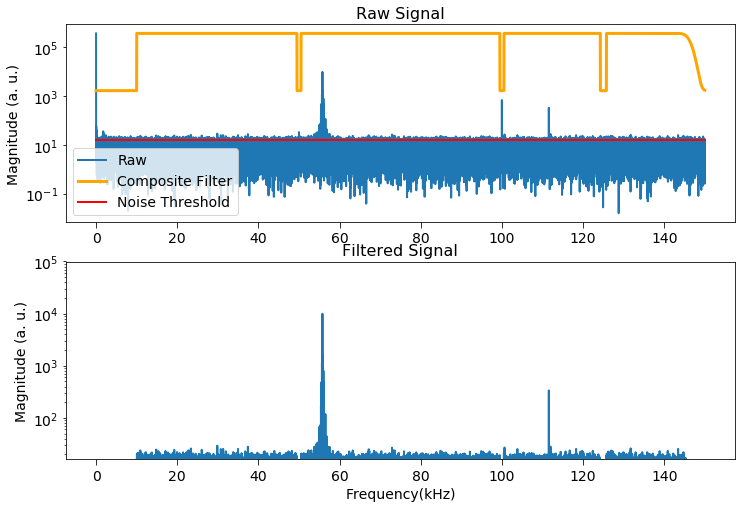

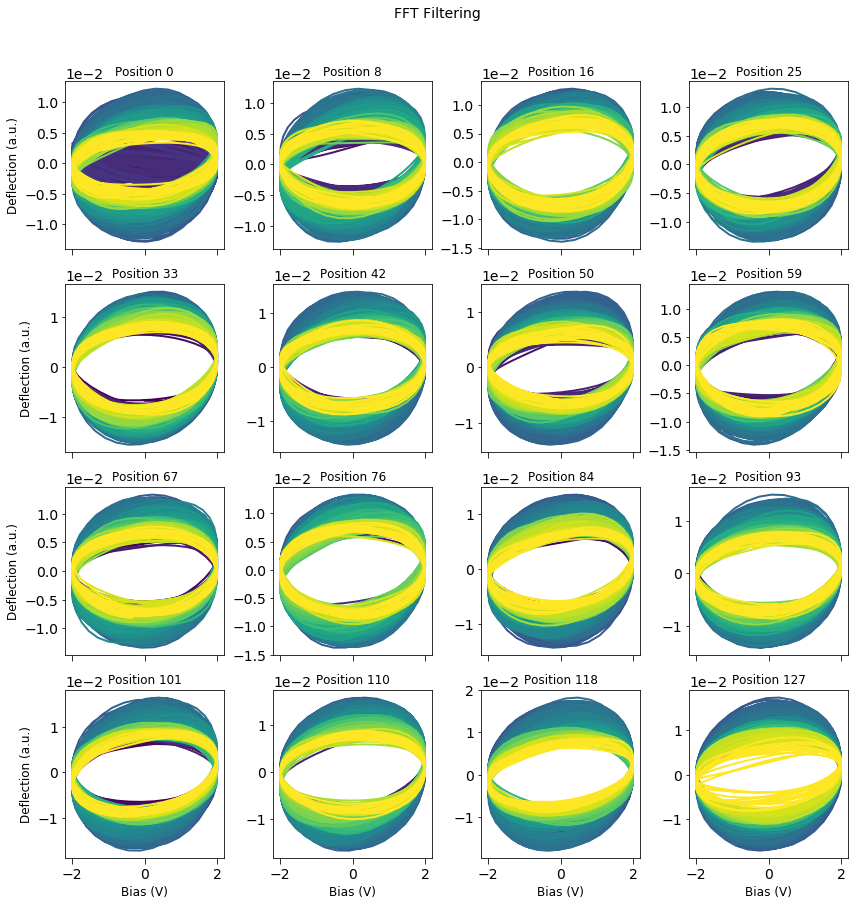

In [21]:

# Set Filter parameters here:
num_spectral_pts = h5_main.shape[1]
#hpf = px.processing.fft.HarmonicPassFilter(num_pts, samp_rate, ex_freq, 1E+3, 10)

lpf = px.processing.fft.LowPassFilter(num_pts, samp_rate, 150E+3)
nbf = px.processing.fft.NoiseBandFilter(num_pts, samp_rate, [125E+3, 50E+3, 5E+3, 100E+3], [1.5E+3, 1E+3, 10E+3, 1E+3])

freq_filts = [lpf, nbf]
noise_tolerance = 0.01

# Test filter on a single line:
row_ind = 9
filt_line, fig_filt, axes_filt = px.processing.gmode_utils.test_filter(h5_main[row_ind], 
                                                                       frequency_filters=freq_filts, 
                                                                       noise_threshold=noise_tolerance, 
                                                                       show_plots=True)
if save_figure == True:
    fig=fig_filt
    fig.savefig(output_filepath+'\FFTFiltering.eps', format='eps')
    fig.savefig(output_filepath+'\FFTFiltering.tif', format='tiff')
    #save_figure = False;
    
filt_row = filt_line.reshape(-1, pixel_ex_wfm.size)
# raw_row = h5_main[row_ind].reshape(-1, pts_per_pix)
fig, axes = px.plot_utils.plot_loops(pixel_ex_wfm, filt_row,use_rainbow_plots=True, x_label='Bias (V)', title='FFT Filtering',
                                     plots_on_side=4, y_label='Deflection (a.u.)')




#### Testing F3R and finding phase on the Filtered row data from previous step

We need to find the phase offset between the measured response and drive voltage. 

<font color=red> I would like the cell below to be interactive such that users can change but the noise limit and phase shift and observe the output changes <br></font>

** <font color=blue> Here you should adjust your phase to close the parabola in the second set of images <br></font> **

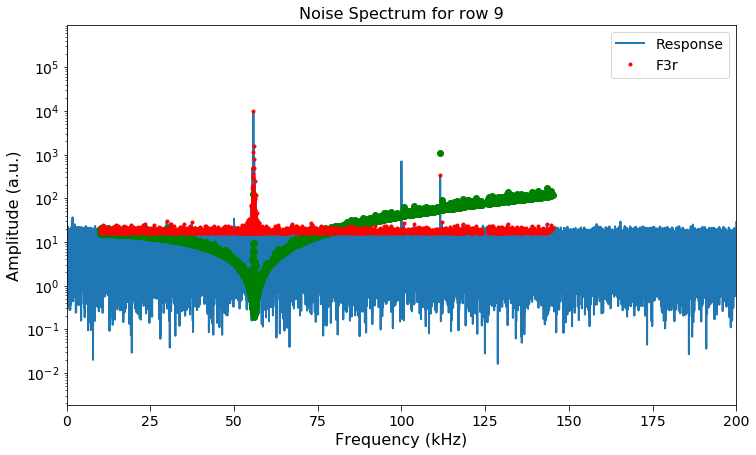

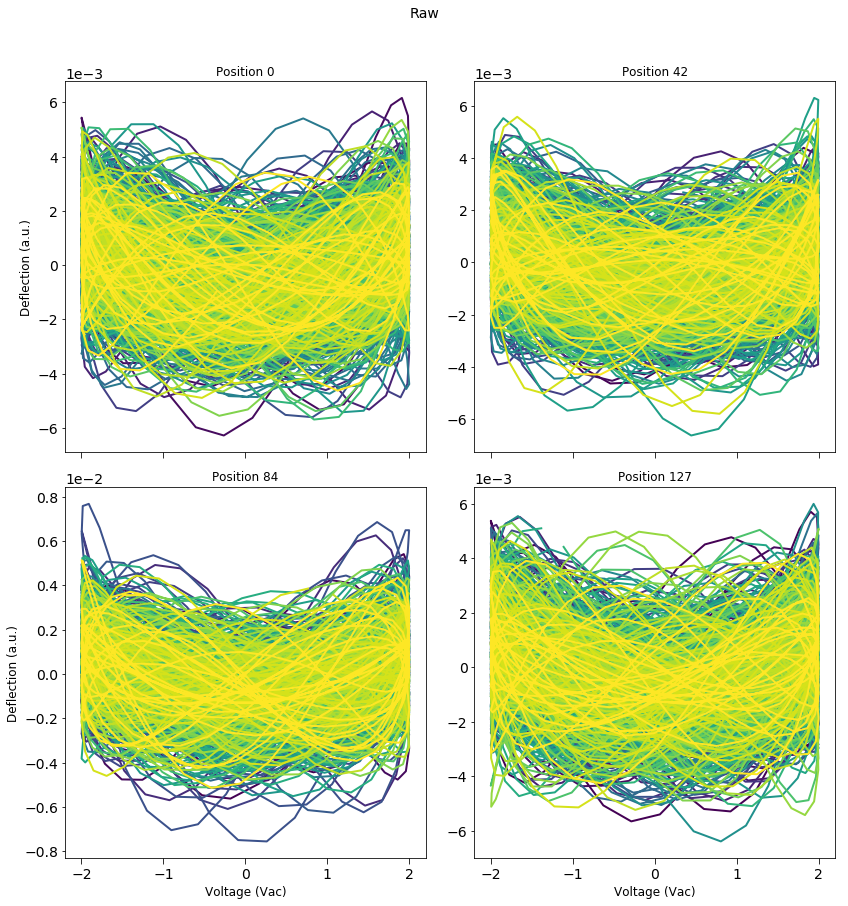

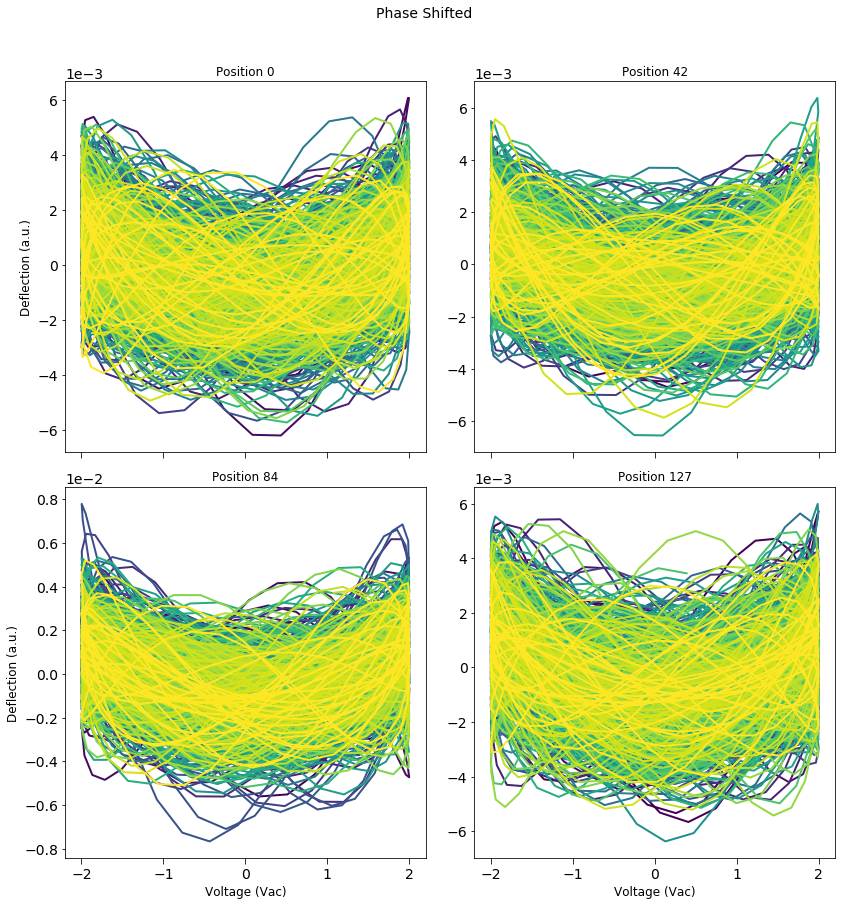

In [22]:
# Try Force Conversion on Filtered data

# Phase Offset
ph=-0.30
Noiselimit=0.1;

# Try Force Conversion on Fitltered data
G=np.zeros(w_vec2.size,dtype=complex)

G_wPhase=np.zeros(w_vec2.size,dtype=complex)



signal_ind_vec=np.arange(w_vec2.size)
ind_drive = (np.abs(w_vec2-ex_freq)).argmin()
test1=filt_line-np.mean(filt_line)
test1=np.fft.fftshift(np.fft.fft(test1))
signal_kill = np.where(np.abs(test1)<Noiselimit)
signal_ind_vec=np.delete(signal_ind_vec,signal_kill)

   
test=(test1)*np.exp(-1j*w_vec2/(w_vec2[ind_drive])*ph)

G_wPhase[signal_ind_vec]=test[signal_ind_vec]
G_wPhase=(G_wPhase/TF_norm)

G_wPhase_time=np.real(np.fft.ifft(np.fft.ifftshift(G_wPhase)))

G[signal_ind_vec]=test1[signal_ind_vec]
G=(G/TF_norm)
G_time=np.real(np.fft.ifft(np.fft.ifftshift(G)))

FRaw_resp = np.fft.fftshift(np.fft.fft(h5_main[row_ind]))

fig, ax = plt.subplots(figsize=(12, 7))
plt.semilogy(w_vec, (np.abs(FRaw_resp)), label='Response')
plt.semilogy(w_vec[signal_ind_vec], (np.abs(G[signal_ind_vec])), 'og')
plt.semilogy(w_vec[signal_ind_vec], (np.abs(FRaw_resp[signal_ind_vec])),'.r', label='F3r')
ax.set_xlabel('Frequency (kHz)', fontsize=16)
ax.set_ylabel('Amplitude (a.u.)', fontsize=16)
ax.legend(fontsize=14)
ax.set_yscale('log')
ax.set_xlim(0, 200)
ax.set_title('Noise Spectrum for row ' + str(row_ind), fontsize=16)
px.plot_utils.set_tick_font_size(ax, 14)



raw=G_time.reshape(-1, pixel_ex_wfm.size)
fig, axes = px.plot_utils.plot_loops(pixel_ex_wfm, raw,use_rainbow_plots=True, x_label='Voltage (Vac)', title='Raw',
                                     plots_on_side=2, y_label='Deflection (a.u.)')

phaseshifed=G_wPhase_time.reshape(-1, pixel_ex_wfm.size)
fig, axes = px.plot_utils.plot_loops(pixel_ex_wfm, phaseshifed,use_rainbow_plots=True, x_label='Voltage (Vac)', title='Phase Shifted',
                                     plots_on_side=2, y_label='Deflection (a.u.)')

#### Filter the full data set

In [23]:
filter_parms = dict()
# if freq_filts is not None:
#     for filter in freq_filts:
#         filter_parms.update(filter.get_parms())
# if noise_tolerance is not None:
#     filter_parms['noise_threshold'] = noise_tolerance

    #h5_filt_grp = px.hdf_utils.check_for_old(h5_main, 'FFT_Filtering', new_parms=filter_parms)

#if h5_filt_grp is None:
sig_filt = px.processing.SignalFilter(h5_main, frequency_filters=freq_filts, noise_threshold=noise_tolerance,
                                      write_filtered=True, write_condensed=False, num_pix=1,verbose=True)
h5_filt_grp = sig_filt.compute()
#else:
#    print('Taking previously computed results')

h5_filt = h5_filt_grp['Filtered_Data']

Allowed to read 42 pixels per chunk
Allowed to use up to 6 cores and 1076.731904 MB of memory
Allowed to read 14 pixels per chunk
Checking for duplicates:
Steps
(1, 1)
[[1]]
Initial Values
(1, 1)
[[0]]
Indices
(1, 1)
[[0]]
/Measurement_000/Channel_000Raw_Data-FFT_Filtering_/Composite_Filter
/Measurement_000/Channel_000Raw_Data-FFT_Filtering_/Noise_Floors
/Measurement_000/Channel_000Raw_Data-FFT_Filtering_/Noise_Spectral_Indices
/Measurement_000/Channel_000Raw_Data-FFT_Filtering_/Noise_Spectral_Values
/Measurement_000/Channel_000Raw_Data-FFT_Filtering_/Filtered_Data
Created group /Measurement_000/Channel_000/Raw_Data-FFT_Filtering_000
Writing attribute: low_pass_cut_off with value: 150000.0
Writing attribute: low_pass_widths with value: 0.05
Writing attribute: samp_rate with value: 2000000
Writing attribute: signal_length with value: 2097152
Writing attribute: noise_band_freqs with value: [ 125000.   50000.    5000.  100000.]
Writing attribute: noise_band_widths with value: [  1500.   1

In [24]:
h5_main_filt = px.hdf_utils.getDataSet(hdf.file,'Filtered_Data')[0]
h5_main_filt.shape

(64, 2097152)

In [25]:
scan_width=1

h5_resh = px.processing.gmode_utils.reshape_from_lines_to_pixels(h5_filt, pixel_ex_wfm.size, scan_width / num_cols)
h5_resh_grp = h5_resh.parent

h5_resh.shape

Starting to reshape G-mode line data. Please be patient
Finished reshaping G-mode line data to rows and columns


(8192, 16384)

#### Does PCA on the filtered response

Performing SVD decomposition
SVD took 7.48 seconds.  Writing results to file.


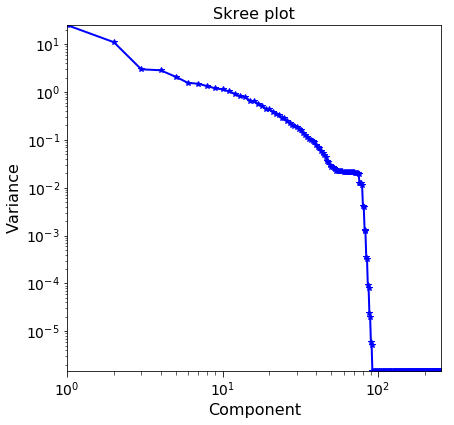

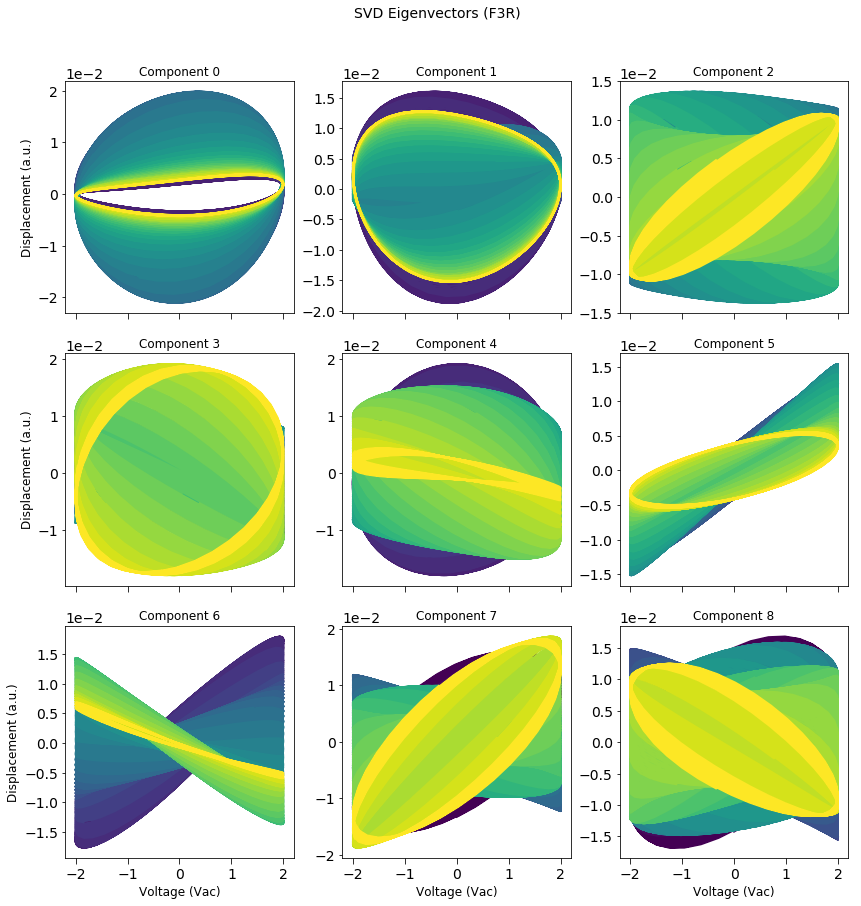

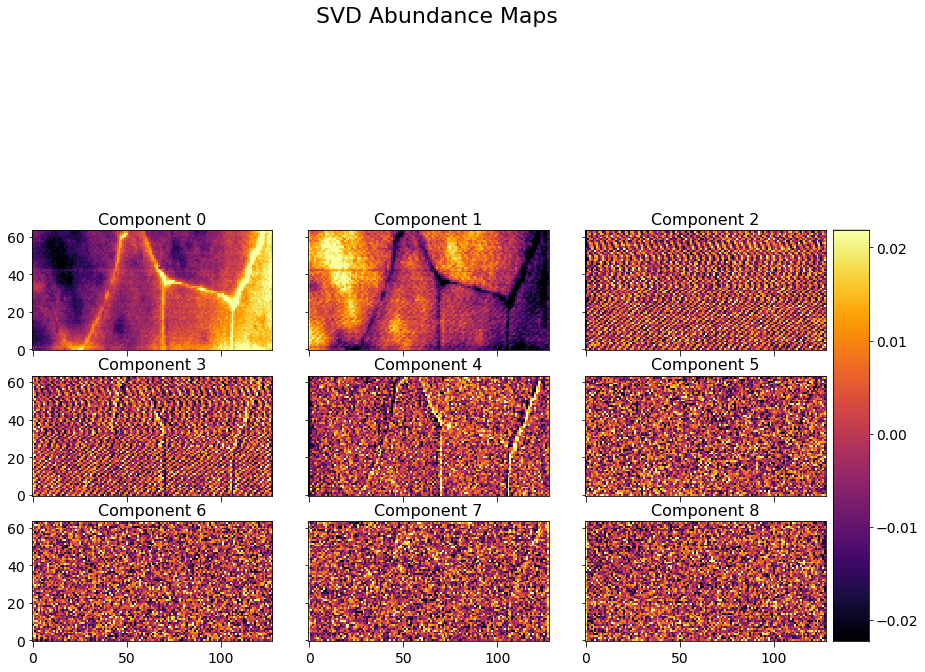

In [31]:
h5_svd = px.processing.svd_utils.SVD(h5_resh, num_components=256)
h5_svd_group = h5_svd.compute()

    
h5_U = h5_svd_group['U']
h5_V = h5_svd_group['V']
h5_S = h5_svd_group['S']

# Since the two spatial dimensions (x, y) have been collapsed to one, we need to reshape the abundance maps:
abun_maps = np.reshape(h5_U[:,:25], (num_rows, num_cols,-1))

# Visualize the variance / statistical importance of each component:
fig, axes =px.plot_utils.plot_scree(h5_S, title='Skree plot')

if save_figure == True:
    fig.savefig(output_filepath+'\PCARaw_Skree.eps', format='eps')
    fig.savefig(output_filepath+'\PCARaw_Skree.tif', format='tiff')
    #save_figure = False;

# Visualize the eigenvectors:
first_evecs = h5_V[:9, :]

fig, axes =px.plot_utils.plot_loops(pixel_ex_wfm, first_evecs, use_rainbow_plots=True, x_label='Voltage (Vac)', y_label='Displacement (a.u.)', plots_on_side=3,
                         subtitle_prefix='Component', title='SVD Eigenvectors (F3R)', evenly_spaced=False)

if save_figure == True:
    fig.savefig(output_filepath+'\PCARaw_Eig.eps', format='eps')
    fig.savefig(output_filepath+'\PCARaw_Eig.tif', format='tiff')
    #save_figure = False;


# Visualize the abundance maps:
fig, axes =px.plot_utils.plot_map_stack(abun_maps, num_comps=9, heading='SVD Abundance Maps',
                             color_bar_mode='single', cmap='inferno')

if save_figure == True:
    fig.savefig(output_filepath+'\PCARaw_Loading.eps', format='eps')
    fig.savefig(output_filepath+'\PCARaw_Loading.tif', format='tiff')
    #save_figure = False;
    


**<font color=blue> Can run this to clean data <br></font>**

clean_components = range(3) # np.append(range(5,9),(17,18))
num_components=len(clean_components)

test=px.svd_utils.rebuild_svd(h5_resh, components=num_components)
PCAcleandata=test[:,:].reshape(num_rows,-1)
PCAcleandata.shape


### Step 3. Fast Free Force Reconstruction 

Below we perform fast free recovery of the electrostatic force by dividing the filtered response by the effective transfer function. We futher set a noise treshold, above which is included in the iFFT transform into the time domain


#### Step(3a, b, c). Divide filtered displacement Y(w) by the effective transfer function (H(w)). <br>

Quite a bit of work done here. (a) Diivde by Transfer function (b) Phase Correction and (c) iFFT the response above a user defined noise floor to recovery Force in time domain.<br>

<font color=red> Maybe we can incorperate this step into the FFT filtering **step (2b** <br></font>

<font color=blue> Here you can adjust Noiselimit which controls iFFT invesion  **step (2b** <br></font>

In [23]:
# Divide Image-data h5_main by Tune-data TF_norm
ind_drive = (np.abs(w_vec2-ex_freq)).argmin()


G=np.zeros(w_vec2.size,dtype=complex)
G_time=np.empty(shape=h5_filt.shape, dtype=h5_filt.dtype)

signal_ind_vec=np.arange(w_vec2.size)

Noiselimit=40
for i in range(num_rows):#h5_filt.shape[0]
    
    signal_ind_vec=np.arange(w_vec2.size)
    
    test1=h5_filt[i,:]-np.mean(h5_filt[i,:])
    #test1=PCAcleandata[i,:]-np.mean(PCAcleandata[i,:])
    test1=np.fft.fftshift(np.fft.fft(test1))
    #test1=np.fft.fftshift(np.fft.fft(filt_line))
    signal_kill = np.where(np.abs(test1)<Noiselimit)
    signal_ind_vec=np.delete(signal_ind_vec,signal_kill)
    test=(test1)*np.exp(-1j*w_vec2/(w_vec2[ind_drive])*ph)
    G[signal_ind_vec]=test[signal_ind_vec]      
    G=G/TF_norm 
    G_time[i,:]=np.real(np.fft.ifft(np.fft.ifftshift(G)))
    
    FRaw_resp = np.fft.fftshift(np.fft.fft(h5_main[i]))

#     fig, ax = plt.subplots(figsize=(12, 7))
#     plt.semilogy(w_vec, (np.abs(FRaw_resp)), label='Response')
#     plt.semilogy(w_vec[signal_ind_vec], (np.abs(G[signal_ind_vec])), 'og')
#     plt.semilogy(w_vec[signal_ind_vec], (np.abs(FRaw_resp[signal_ind_vec])),'.r', label='F3r')
#     ax.set_xlabel('Frequency (kHz)', fontsize=16)
#     ax.set_ylabel('Amplitude (a.u.)', fontsize=16)
#     ax.legend(fontsize=14)
#     ax.set_yscale('log')
#     ax.set_xlim(0, 200)
#     ax.set_title('Noise Spectrum for row ' + str(i), fontsize=16)
#     px.plot_utils.set_tick_font_size(ax, 14)
    
#     phaseshifed=G_time[i].reshape(-1, pixel_ex_wfm.size)
#     fig, axes = px.plot_utils.plot_loops(pixel_ex_wfm, phaseshifed,use_rainbow_plots=True, x_label='Voltage (Vac)', title='Phase Shifted',
#                                      plots_on_side=2, y_label='Deflection (a.u.)')
    
   

#### Check a row to make sure it worked

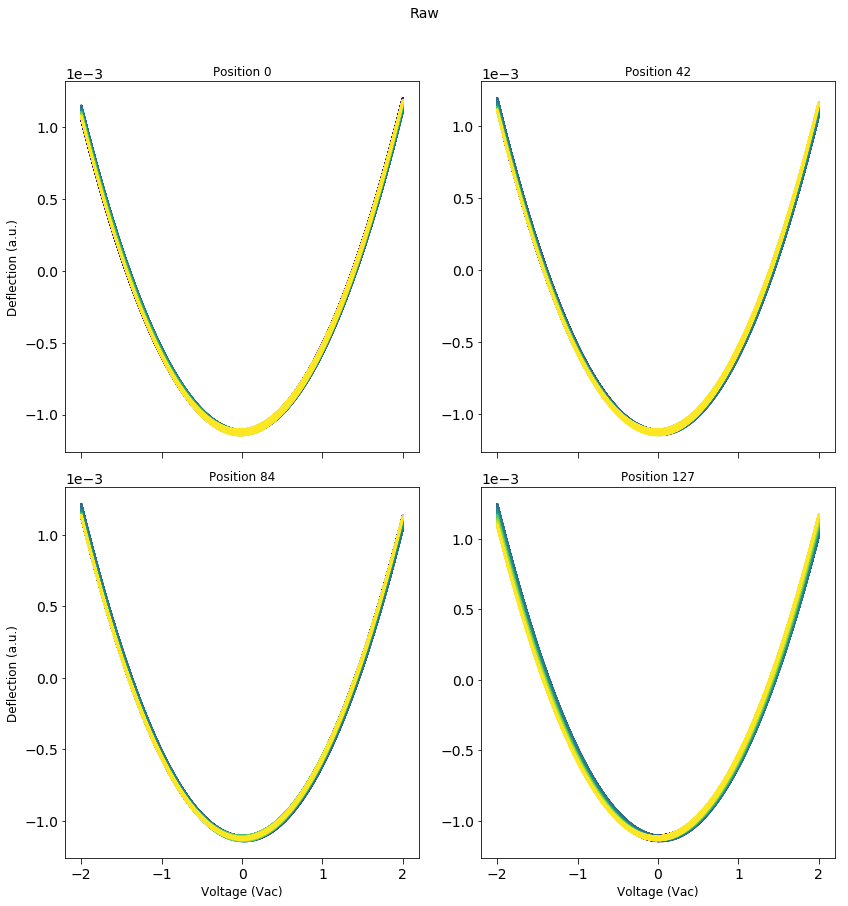

In [24]:


raw=G_time[row_ind].reshape(-1,pixel_ex_wfm.size)


fig, axes = px.plot_utils.plot_loops(pixel_ex_wfm, raw,use_rainbow_plots=True, x_label='Voltage (Vac)', title='Raw',
                                     plots_on_side=2, y_label='Deflection (a.u.)')

#### Reshaping and Storing  Results


In [25]:
h5_F3R = px.hdf_utils.create_empty_dataset(source_dset=h5_filt, dtype=h5_filt.dtype, dset_name='h5_F3R', new_attrs=dict(), skip_refs=False)
px.hdf_utils.copy_main_attributes(h5_filt,h5_F3R)
h5_F3R[:,:]=G_time[:,:]
h5_F3R.file.flush()

px.hdf_utils.link_as_main(h5_main=h5_F3R, h5_pos_inds=h5_pos_inds, h5_pos_vals=h5_pos_vals, h5_spec_inds=h5_spec_inds, h5_spec_vals=h5_spec_vals, anc_dsets=[])

h5_F3R.shape

(64, 2097152)


raw=h5_F3R[row_ind].reshape(-1,pixel_ex_wfm.size)
print(raw.shape)

fig, axes = px.plot_utils.plot_loops(pixel_ex_wfm, raw,use_rainbow_plots=True, x_label='Voltage (Vac)', title='Raw',
                                     plots_on_side=2, y_label='Deflection (a.u.)')

In [26]:
h5_F3rresh_grp = px.hdf_utils.findH5group(h5_F3R, 'Reshape')
# if len(h5_F3rresh_grp) > 0:
#     print('Taking previously reshaped results')
#     h5_F3rresh_grp = h5_F3rresh_grp[-1]
#     h5_F3rresh = h5_F3rresh_grp['Reshaped_Data'] 
# else:
#     print('Reshape not performed on this dataset. Reshaping now:')
scan_width = 1
h5_F3rresh = px.processing.gmode_utils.reshape_from_lines_to_pixels(h5_F3R, pixel_ex_wfm.size, scan_width / num_cols)
h5_F3rresh_grp = h5_F3rresh.parent

print('Data was reshaped from shape', h5_F3R.shape,
      'reshaped to ', h5_F3rresh.shape)

Starting to reshape G-mode line data. Please be patient
Finished reshaping G-mode line data to rows and columns
Data was reshaped from shape (64, 2097152) reshaped to  (8192, 16384)


raw = np.reshape(h5_F3rresh, [-1, pixel_ex_wfm.size])
fig, axes = px.plot_utils.plot_loops(pixel_ex_wfm, raw[128:256],use_rainbow_plots=True, x_label='Voltage (Vac)', title='Raw',
                                     plots_on_side=2, y_label='Deflection (a.u.)')

#### DO PCA on F3R recovered data




Performing SVD decomposition
SVD took 8.01 seconds.  Writing results to file.


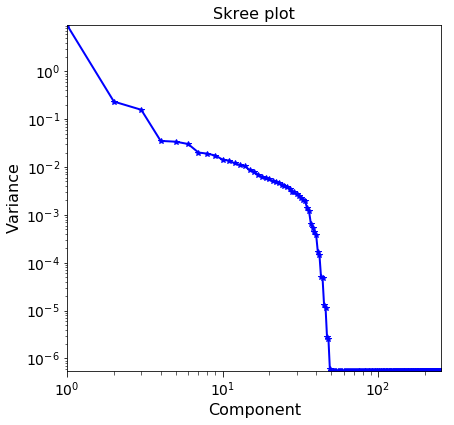

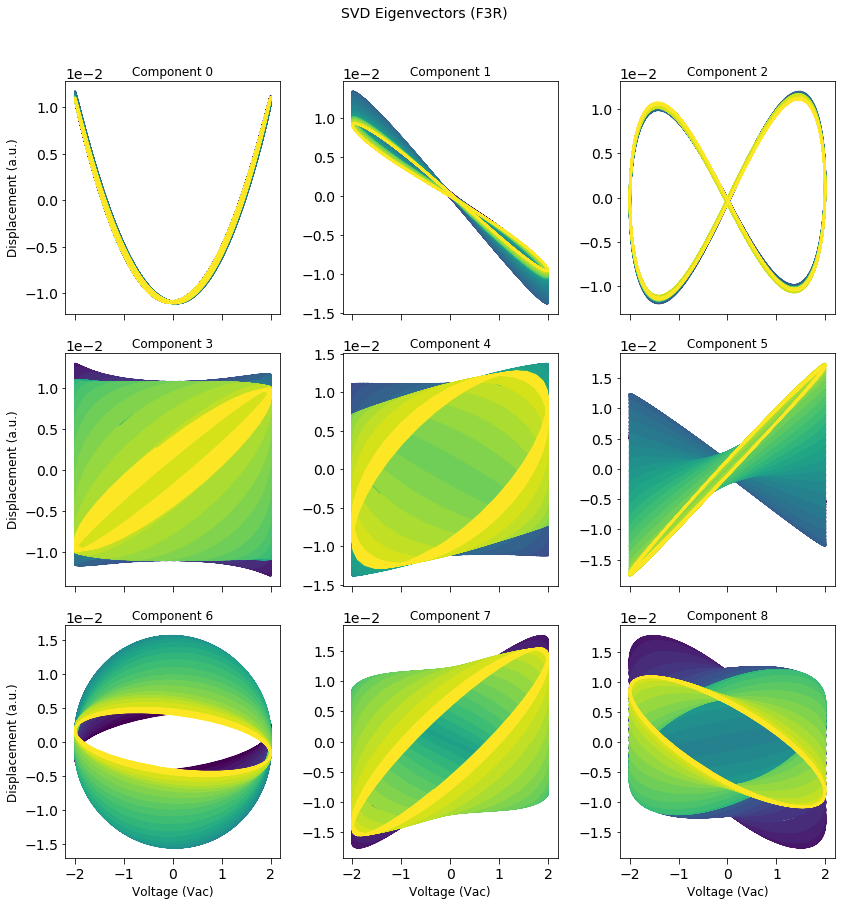

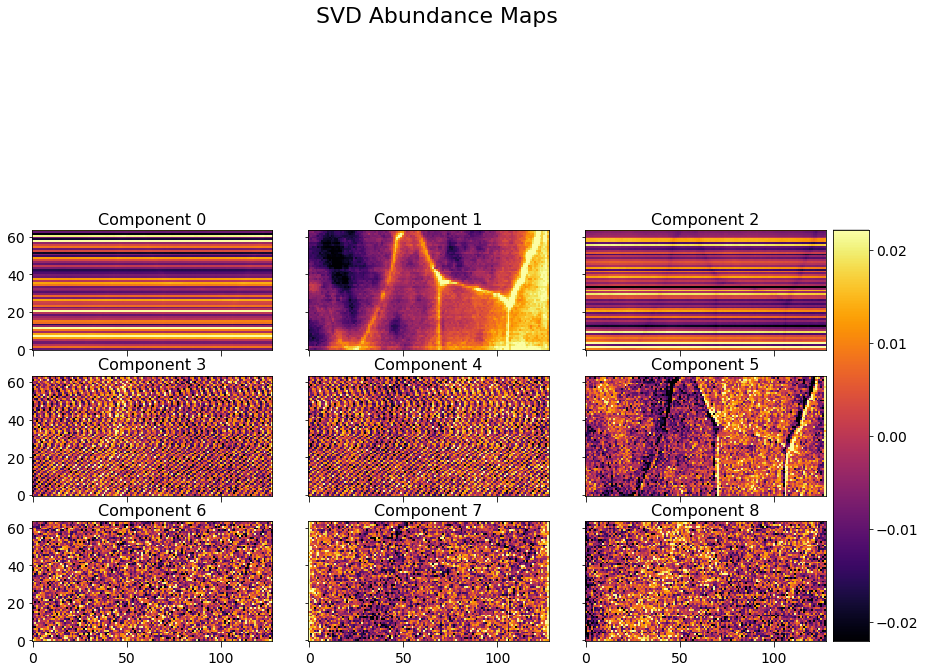

In [36]:
do_svd = px.processing.svd_utils.SVD(h5_F3rresh, num_components=256)
h5_svd_group = do_svd.compute()

h5_u = h5_svd_group['U']
h5_v = h5_svd_group['V']
h5_s = h5_svd_group['S']

# Since the two spatial dimensions (x, y) have been collapsed to one, we need to reshape the abundance maps:
abun_maps = np.reshape(h5_u[:,:25], (num_rows, num_cols,-1))

# Visualize the variance / statistical importance of each component:
fig, axes =px.plot_utils.plot_scree(h5_s, title='Skree plot')

if save_figure == True:
    fig.savefig(output_filepath+'\PCAF3R_Skree.eps', format='eps')
    fig.savefig(output_filepath+'\PCF3R_Skree.tif', format='tiff')

# Visualize the eigenvectors:
first_evecs = h5_v[:9, :]

fig, axes =px.plot_utils.plot_loops(pixel_ex_wfm, first_evecs, x_label='Voltage (Vac)', use_rainbow_plots=True, y_label='Displacement (a.u.)', plots_on_side=3,
                         subtitle_prefix='Component', title='SVD Eigenvectors (F3R)', evenly_spaced=False)

if save_figure == True:
    fig.savefig(output_filepath+'\PCAF3R_Eig.eps', format='eps')
    fig.savefig(output_filepath+'\PCF3R_Eig.tif', format='tiff')
    
    
# Visualize the abundance maps:
fig, axes =px.plot_utils.plot_map_stack(abun_maps, num_comps=9, heading='SVD Abundance Maps',
                             color_bar_mode='single', cmap='inferno')
if save_figure == True:
    fig.savefig(output_filepath+'\PCAF3R_Loadings.eps', format='eps')
    fig.savefig(output_filepath+'\PCF3R_Loadings.tif', format='tiff')

### Parabolic Fitting of Cleaned Data

<font color=red> Again, can we speed up/ parallelize it?. <br></font> 
<font color=red> It would be nice to have some sort of visualization of a subset of fits. <br></font> 
<font color=red> It would be nice to have some sort of visualization of a subset of fits. <br></font> 



It would also be nice to have the options of how many oscillations you fit over (period-1/fdrive )



### Here you can PCA clean data if you like

In [37]:
clean_components = np.append(range(0,2),(5)) ##Components you want to keep 
num_components=len(clean_components)

test=px.svd_utils.rebuild_svd(h5_F3rresh, components=num_components)
PCAcleandata=test[:,:].reshape(num_rows*num_cols,-1)
PCAcleandata.shape

Reconstructing in batches of 2731 positions.
Batchs should be 512.0937538146973 Mb each.
Completed reconstruction of data from SVD results.  Writing to file.
Done writing reconstructed data to file.


(8192, 16384)

def single_poly(h5_resh,pixel_ex_wfm, m, pnts_per_per, k4):
    resp=h5_resh[m][pnts_per_per*k4:pnts_per_per*(k4+1)]

    resp=resp-np.mean(resp)

    V_per_osc=pixel_ex_wfm[pnts_per_per*k4:pnts_per_per*(k4+1)]
    p1,s=npPoly.polyfit(V_per_osc,resp,deg,full=True)
    y1=npPoly.polyval(V_per_osc,p1)
    print('pixel: ' + str(m) + 'period: ' + str(k4))
    return y1

### Test fitting on sample data

In [26]:
per1=1 ##this is number of periods you want to average over, for best time resolution =1 (but takes longer to fit)


time_per_osc=1/parms_dict['BE_center_frequency_[Hz]']
IO_rate=parms_dict['IO_rate_[Hz]']

pxl_time=N_points_per_pixel/IO_rate
num_periods=int((round(pxl_time/time_per_osc))/per1) 
pnts_per_per=int(round(N_points_per_pixel/num_periods))
   
time=np.arange(0,pxl_time,num_periods)
  
deg=2

m=2

k4=100

##Raw F3R response
resp=h5_F3rresh[m][pnts_per_per*k4:pnts_per_per*(k4+1)]

##Comment below and uncomment above if you dont want to use PCA clean data
#resp=PCAcleandata[m][pnts_per_per*k4:pnts_per_per*(k4+1)]

resp=resp-np.mean(resp)
V_per_osc=pixel_ex_wfm[pnts_per_per*k4:pnts_per_per*(k4+1)]


p1,s=npPoly.polyfit(V_per_osc,resp,deg,full=True)
y1=npPoly.polyval(V_per_osc,p1)





plt.figure(k4)
plt.plot(V_per_osc,resp)
plt.plot(V_per_osc,y1)


NameError: name 'h5_F3rresh' is not defined

### Repeat on the full dataset

In [27]:
per=4 ##this is number of periods you want to average over, for best time resolution =1 (but takes longer to fit)


time_per_osc=(1/parms_dict['BE_center_frequency_[Hz]'])*per
IO_rate=parms_dict['IO_rate_[Hz]']
pxl_time=N_points_per_pixel/IO_rate
num_periods=int((round(pxl_time/time_per_osc)))  
pnts_per_per=int(round(N_points_per_pixel/num_periods))
   
time=np.linspace(0.0,pxl_time,num_periods)
  
deg=2
wHfit3=np.zeros((num_rows*num_cols,num_periods,deg+1))
#error=np.zeros((num_rows,num_cols,osc_period,pixel_per_osc))
do_plot=False
for n in range((num_rows*num_cols)):     
    for k4 in range(num_periods):#osc_period
        #resp=PCAcleandata[n][pnts_per_per*k4:pnts_per_per*(k4+1)]
        resp=h5_F3rresh[n][pnts_per_per*k4:pnts_per_per*(k4+1)]

        resp=resp-np.mean(resp)
        V_per_osc=pixel_ex_wfm[pnts_per_per*k4:pnts_per_per*(k4+1)]
        p1,s=npPoly.polyfit(V_per_osc,resp,deg,full=True)
        y1=npPoly.polyval(V_per_osc,p1)           
             
        wHfit3[n,k4,:]=p1
        
        
  
   
CPD=-0.5*np.divide(wHfit3[:,:,1],wHfit3[:,:,0]) 

NameError: name 'h5_F3rresh' is not defined

n_list = range(num_rows*num_cols)
k4_list = range(num_periods)

args = [[pixel_ex_wfm, n, pnts_per_per, k4] for (k4, n) in zip(k4_list, n_list)]



values = [joblib.delayed(single_poly)(x, *args) for x in PCAcleandata]

## Store to H5

In [42]:
dset = hdf.file.create_dataset("parafit_main", shape=wHfit3.shape, dtype=np.float32)
dset[:,:] = wHfit3

hdf.file.flush()

Text(0,0.5,'CPD (V)')

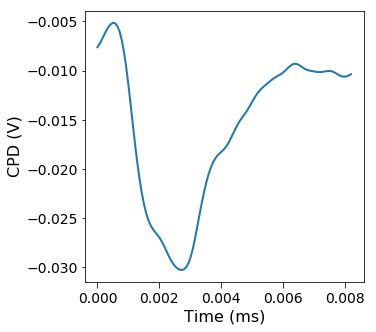

In [43]:
test=CPD[100,:]
time=np.linspace(0.0,pxl_time,num_periods)
  
plt.figure(1)
plt.plot(time,test)
plt.xlabel('Time (ms)', fontsize=16)
plt.ylabel('CPD (V)', fontsize=16)

In [44]:
CPD_off = CPD
CPD_on = CPD

## Data Visualization 
#### PCA of the CPD data

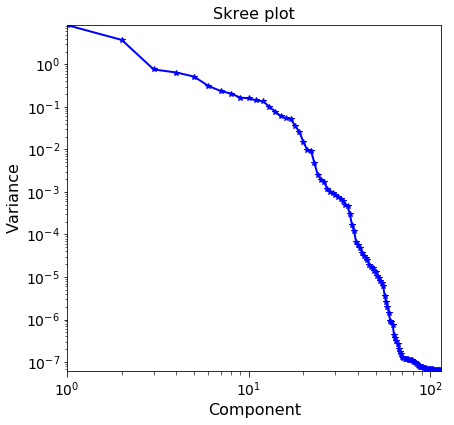

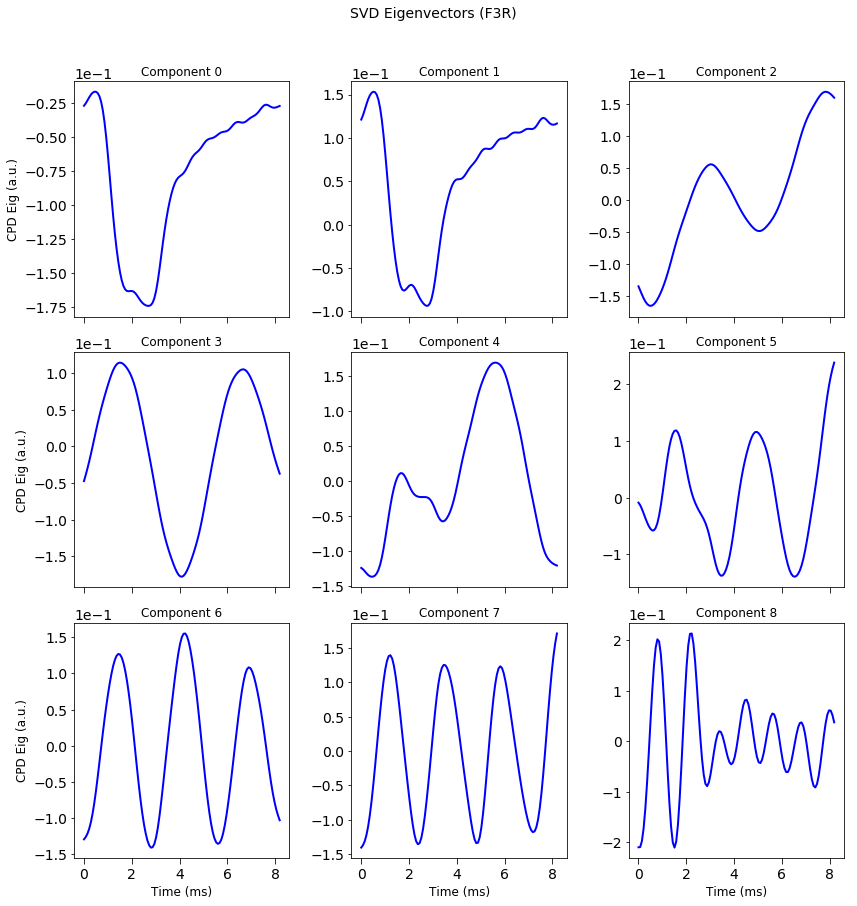

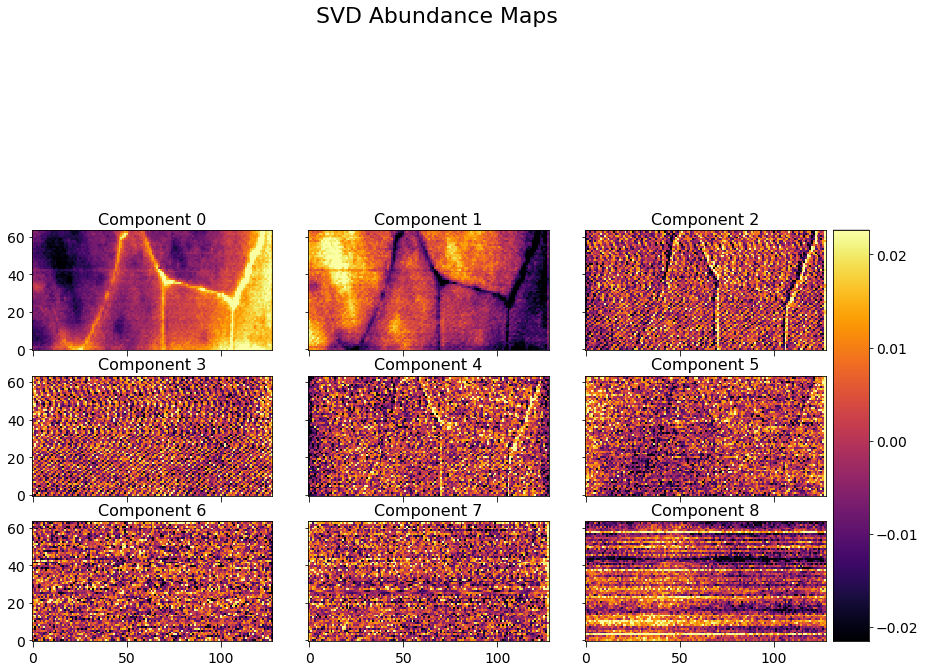

In [45]:
######## do_svd = px.processing.svd_utils.SVD(h5_F3R, num_components=256)
######## h5_svd_group = do_svd.compute()
from sklearn.utils.extmath import randomized_svd

U, S, V = randomized_svd(CPD, 256, n_iter=3)
#######U, S, V = randomized_svd(h5_filt[:].reshape([-1, pixel_ex_wfm.size]), 256, n_iter=3)
######## h5_u = h5_svd_group['U']
####### h5_v = h5_svd_group['V']
####### h5_s = h5_svd_group['S']

####### Since the two spatial dimensions (x, y) have been collapsed to one, we need to reshape the abundance maps:
abun_maps = np.reshape(U[:,:25], (num_rows, num_cols,-1))

########### Visualize the variance / statistical importance of each component:
fig, axes = px.plot_utils.plot_scree(S, title='Skree plot')

if save_figure == True:
    fig.savefig(output_filepath+'\PCACPD_Skree.eps', format='eps')
    fig.savefig(output_filepath+'\PCACPD_Skree.tif', format='tiff')
    

######### Visualize the eigenvectors:
first_evecs = V[:9, :]

fig, axes =px.plot_utils.plot_loops(time*1E+3, first_evecs, x_label='Time (ms)', y_label='CPD Eig (a.u.)', plots_on_side=3,
                         subtitle_prefix='Component', title='SVD Eigenvectors (F3R)', evenly_spaced=False)

if save_figure == True:
    fig.savefig(output_filepath+'\PCACPD_Eig.eps', format='eps')
    fig.savefig(output_filepath+'\PCACPD_Eig.tif', format='tiff')
    
############ Visualize the abundance maps:
fig, axes =px.plot_utils.plot_map_stack(abun_maps, num_comps=9, heading='SVD Abundance Maps',
                             color_bar_mode='single', cmap='inferno')

if save_figure == True:
    fig.savefig(output_filepath+'\PCACPD_Loadings.eps', format='eps')
    fig.savefig(output_filepath+'\PCACPD_Loadings.tif', format='tiff')
